In [1]:
from pathlib import Path
import sys

root = str(Path().resolve().parents[0])
if root not in sys.path:
    sys.path.append(root)

from src.utils import ROOT, DATA_DIR, EXPERIMENTS_DIR, OUTPUT_DIR, DATA_PATHS

for path in [ROOT, DATA_DIR, EXPERIMENTS_DIR, OUTPUT_DIR]:
    if str(path.resolve()) not in sys.path:
        sys.path.append(str(path.resolve()))

print(*sys.path, sep="\n")

from importlib import reload
import src

reload(src)
reload(src.utils)
reload(src.custom_transformers)
reload(src.custom_model_selection)
reload(src.experiment_runner)
reload(src.config_parser)

/usr/lib/python312.zip
/usr/lib/python3.12
/usr/lib/python3.12/lib-dynload

/home/ryanwtsai/repos/ml_ai_portfolio/notes/example_code/venv/lib/python3.12/site-packages
/home/ryanwtsai/repos/ml_ai_portfolio/titanic
/home/ryanwtsai/repos/ml_ai_portfolio/titanic/dataset
/home/ryanwtsai/repos/ml_ai_portfolio/titanic/experiments
/home/ryanwtsai/repos/ml_ai_portfolio/titanic/outputs


<module 'src.config_parser' from '/home/ryanwtsai/repos/ml_ai_portfolio/titanic/src/config_parser.py'>

In [ ]:
import yaml
from src.config_parser import build_estimators

config_fname = EXPERIMENTS_DIR / "004c_age_imputer_cv/config.yaml"

with open(config_fname, "r") as f:
    config = yaml.safe_load(f)

estimators = build_estimators(config)
estimators


In [ ]:
import joblib

serialized_pipe = EXPERIMENTS_DIR / "004c_age_imputer_cv/ml_pipeline.joblib"
age_imputer = joblib.load(serialized_pipe)
age_imputer.named_steps["data_prep"].pipeline_

In [15]:
from src.utils import load_titanic_data
import numpy as np
df, _, _ = load_titanic_data(load_X_y=False, extracted=True)

missing_age = df.Age.isna()
df["AgeImputed"] = df["Age"]
ages = age_imputer.predict(df.loc[missing_age])
df.loc[missing_age, "AgeImputed"] = ages
ages = age_imputer.predict(df)
df["AllAgeImputed"] = ages
df["MAE"] = df["Age"]
df.loc[~missing_age, "MAE"] = np.abs(df.loc[~missing_age, "Age"] - df.loc[~missing_age, "AllAgeImputed"])
print(df["MAE"].describe())
print("")
print(df["MAE"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]))
print("")

count    714.000000
mean       8.278542
std        6.775050
min        0.092538
25%        3.317461
50%        6.984085
75%       11.454366
max       44.545634
Name: MAE, dtype: float64

0.50     6.984085
0.75    11.454366
0.90    17.118421
0.95    21.509610
0.99    31.579617
Name: MAE, dtype: float64



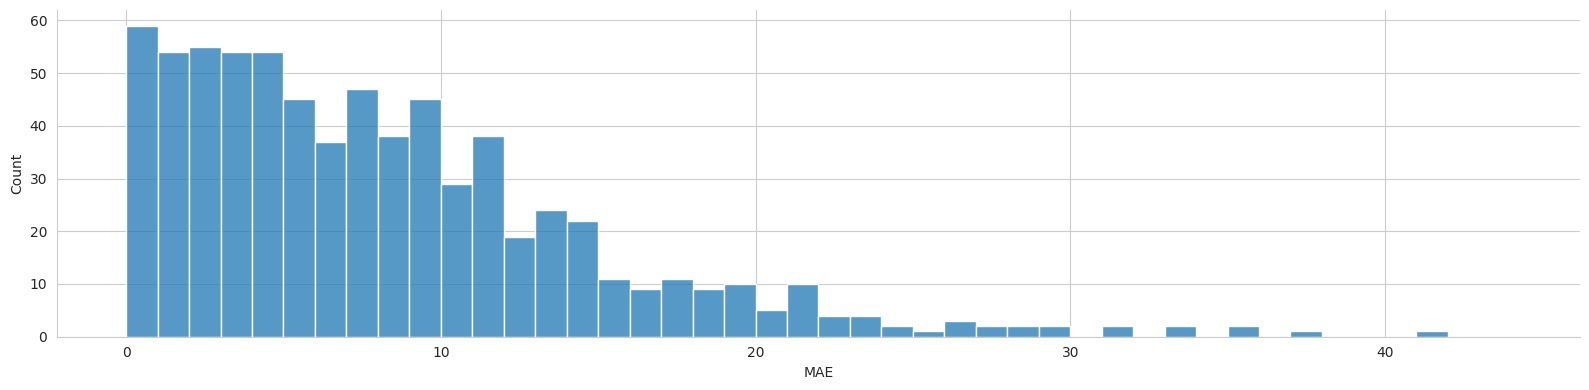

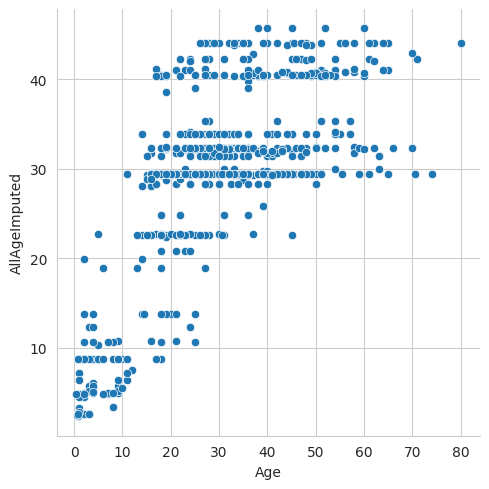

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

g = sns.displot(df, kind="hist", x="MAE", height=4, aspect=4, bins=range(0,np.ceil(df["MAE"].max()).astype("int").item()))
g = sns.relplot(df.loc[~missing_age], kind="scatter", x="Age", y="AllAgeImputed")

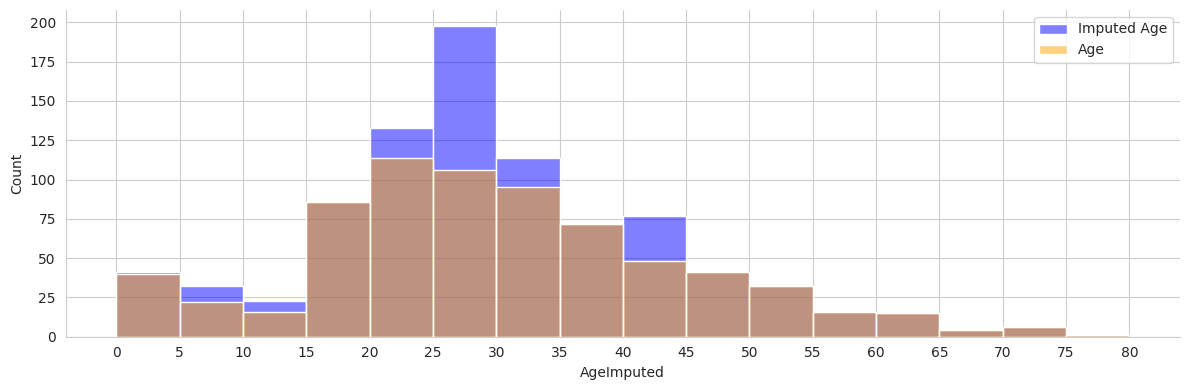

In [19]:
g = sns.displot(df, kind="hist", x="AgeImputed", bins=range(0, 85, 5), height=4, aspect=3, color="blue", alpha=0.5, label="Imputed Age")
ax = sns.histplot(df, x="Age", bins=range(0, 85, 5), ax=g.ax, color="orange", alpha=0.5, label="Age")
_ = ax.set_xticks(range(0, 85,5))
_ = ax.legend()

        AgeImputed                                                     \
             count       mean        std    min        25%        50%   
Title                                                                   
Dr             7.0  42.030995  10.969962  23.00  37.108481  44.000000   
Master        40.0   4.641309   3.442348   0.42   1.750000   4.000000   
Miss         185.0  21.196469  11.993614   0.75  13.802031  22.000000   
Mr           517.0  32.278272  11.424960  11.00  25.000000  29.454366   
Mrs          126.0  35.781810  10.765884  14.00  28.250000  35.000000   
Rev            6.0  43.166667  13.136463  27.00  31.500000  46.500000   
Unknown       10.0  49.100000  11.029758  33.00  41.250000  48.500000   

                            Age                                            \
               75%   max  count       mean        std    min    25%   50%   
Title                                                                       
Dr       49.500000  54.0    6.0  42.00

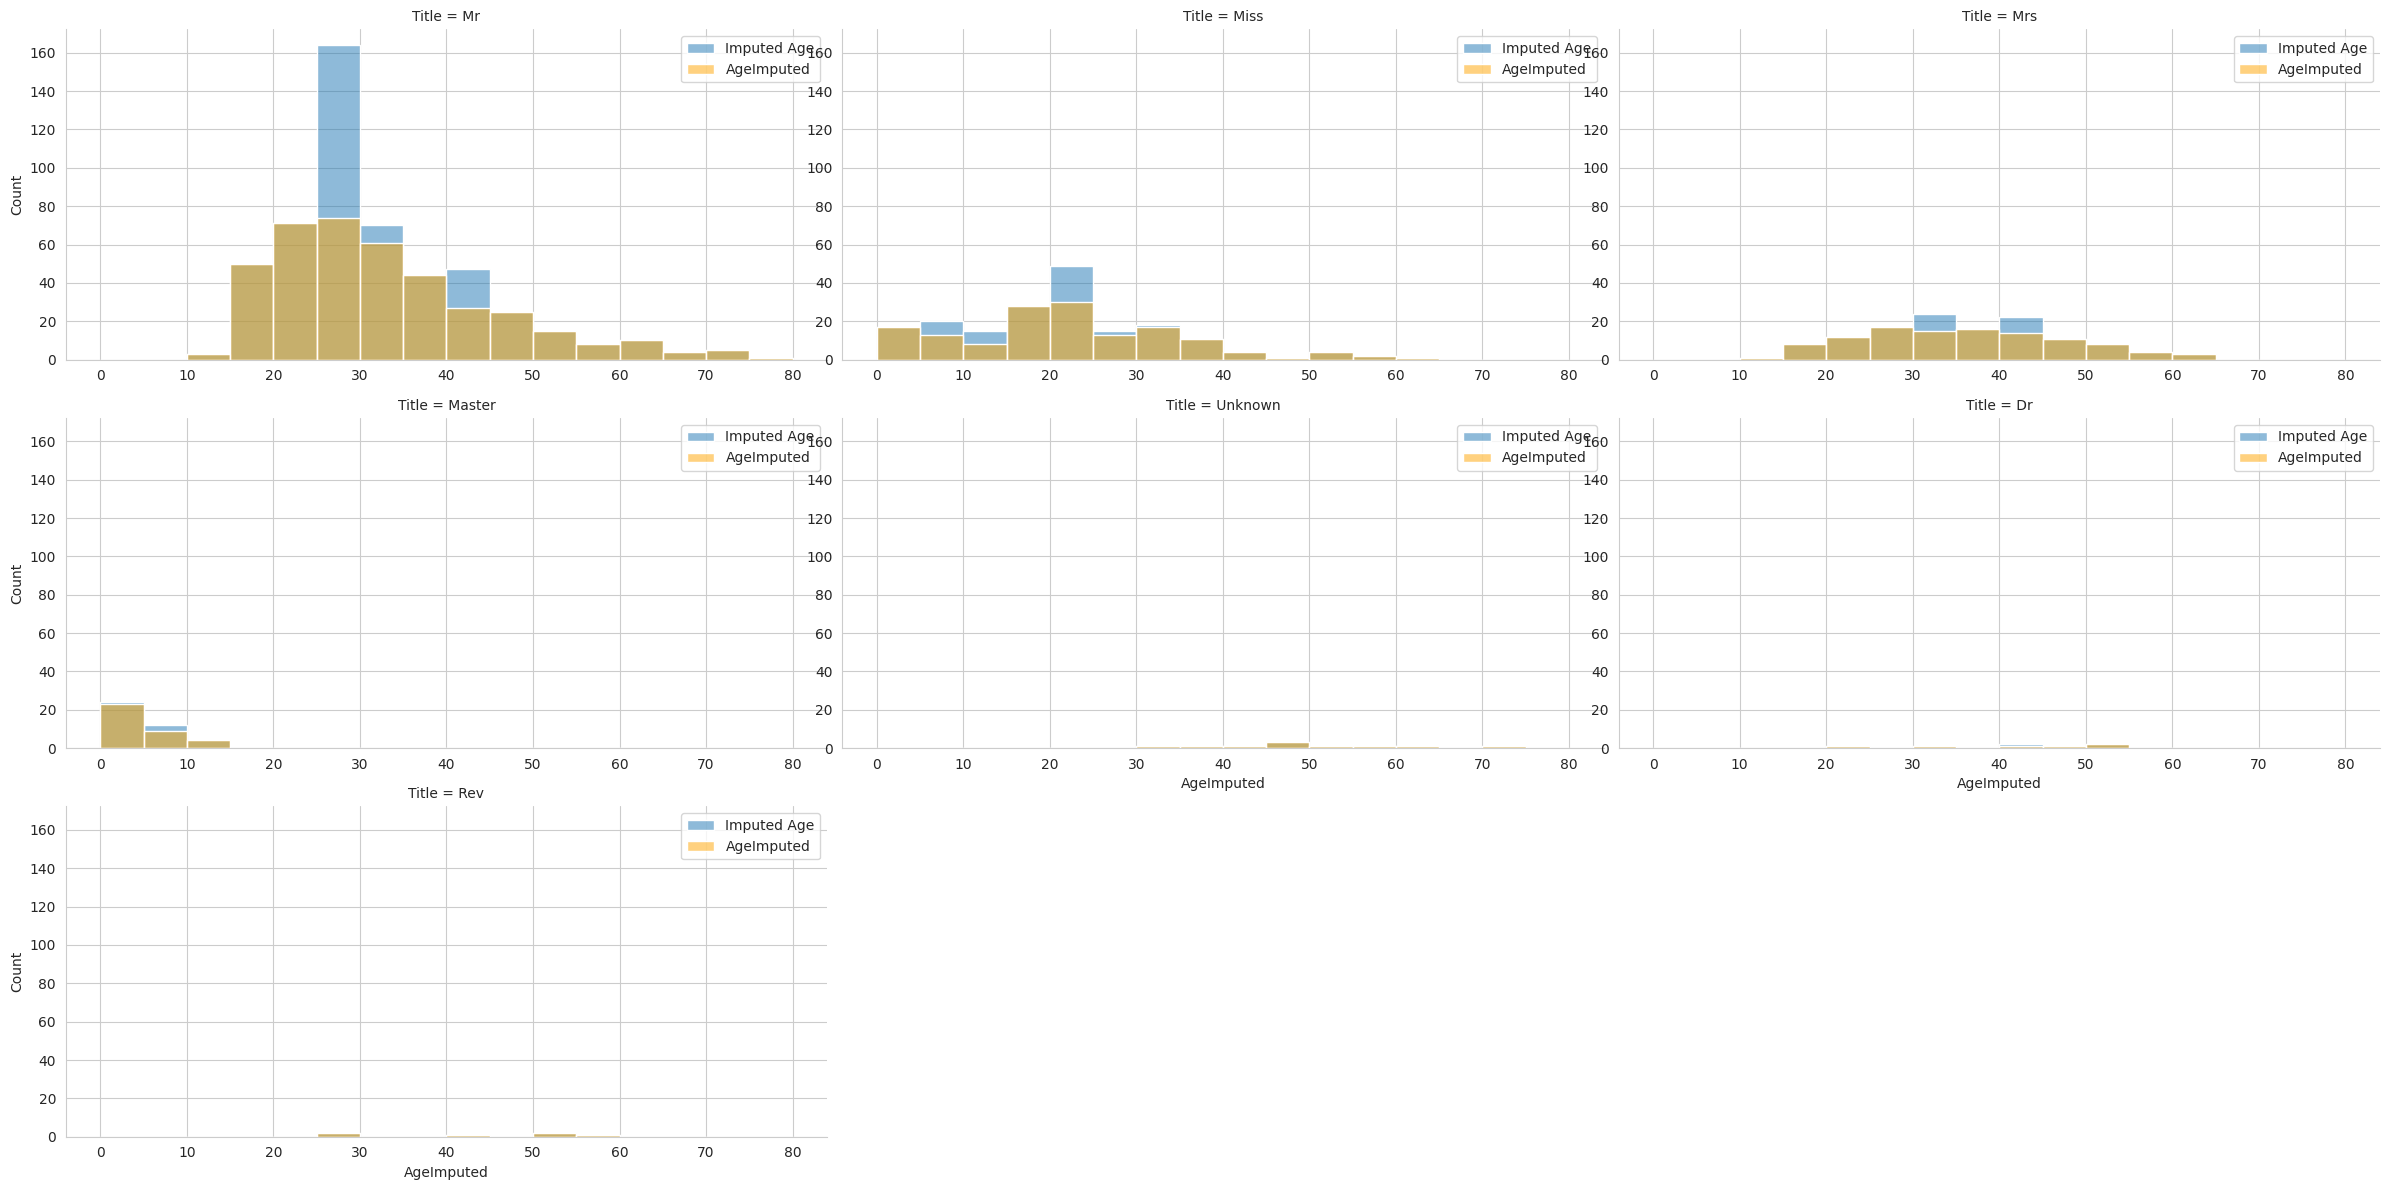

In [20]:
print(df.groupby("Title")[["AgeImputed", "Age"]].describe())
print("")

g = sns.displot(df, kind="hist", bins=range(0, 85, 5), x="AgeImputed", col="Title", col_order=df.Title.value_counts().sort_values(ascending=False).index, col_wrap=3, height=4, aspect=2, alpha=0.5, label="Imputed Age")
ax_iter = g.axes.flat
for i, sz in enumerate(df.Title.value_counts().sort_values(ascending=False).index):
    ax = next(ax_iter)
    _ = sns.histplot(df.query("Title == @sz"), bins=range(0, 85, 5), x="Age", alpha=0.5, color="orange", label="AgeImputed", ax=ax)
    _ = ax.legend()

for ax in g.axes.flat:
    ax.tick_params(labelbottom=True, labelleft=True)